# THE VISUALIZATIONS ARE COMMENTED OUT FOR SPACE SAKE! PLEASE UNCOMMENT TO SEE THEM. IF I UPLOAD WITH VISUALIZATIONS, THE FILE IS TOO LARGE!

In [1]:
%load_ext nb_black
from collections import Counter
from umap import UMAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

<IPython.core.display.Javascript object>

In [2]:
# useful functions
def pca_loadings(pca):
    return pca.components_.T * np.sqrt(pca.explained_variance_)


def plot_dendrogram(model, **kwargs):
    """
    A function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: None   
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv(r"C:\Users\jonat\Desktop\Stocks\prices.csv")
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


<IPython.core.display.Javascript object>

In [4]:
# That is pretty... pretty cluttered. We should prob try to group stocks
# px.scatter(x="date", y="open", color="symbol", data_frame=df)

<IPython.core.display.Javascript object>

In [5]:
# Let's make date date-time and separate based on month, day, and year.
df["date"] = df["date"].str.replace("00:00:00", "")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
# now we drop date since it's kinda useless to us
df = df.drop(columns="date")

<IPython.core.display.Javascript object>

In [6]:
df

,symbol,open,close,low,high,volume,year,month,day
0,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2016,1,5
1,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,2016,1,6
2,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,2016,1,7
3,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,2016,1,8
4,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,2016,1,11
...,...,...,...,...,...,...,...,...,...
851259,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,2016,12,30
851260,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,2016,12,30
851261,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,2016,12,30
851262,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,2016,12,30


<IPython.core.display.Javascript object>

In [7]:
# I don't want the date to be an object. Datetime is easier to work with for groupings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
 6   year    851264 non-null  int64  
 7   month   851264 non-null  int64  
 8   day     851264 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 58.5+ MB


<IPython.core.display.Javascript object>

In [8]:
# Are there any NA?
df.isna().mean()

symbol    0.0
open      0.0
close     0.0
low       0.0
high      0.0
volume    0.0
year      0.0
month     0.0
day       0.0
dtype: float64

<IPython.core.display.Javascript object>

In [9]:
low_stocks = df.symbol.value_counts()
Counter(low_stocks)

Counter({1762: 467,
         1761: 1,
         1683: 1,
         1540: 1,
         1008: 13,
         987: 1,
         896: 1,
         894: 1,
         892: 2,
         853: 1,
         786: 1,
         504: 4,
         385: 1,
         378: 2,
         304: 1,
         284: 1,
         251: 1,
         126: 1})

<IPython.core.display.Javascript object>

In [10]:
# I want to see how many full counts we have. Will look at full then set everything to minimum dates.
# For now, dropping those who don't have 1762
count = 0
for i in low_stocks:
    if i == 1762:
        count += 1
    else:
        count = count

print(count)

467


<IPython.core.display.Javascript object>

In [11]:
# keeping CHTR because it's only missing one
to_drop = low_stocks.tail(34)
pls_work = to_drop.reset_index()
drop = pls_work["index"].values
df["symbol"] = df["symbol"].replace(drop, "NaN")
df["symbol"]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
851259     ZBH
851260    ZION
851261     NaN
851262     AIV
851263     NaN
Name: symbol, Length: 851264, dtype: object

<IPython.core.display.Javascript object>

In [12]:
df_full = df[~df["symbol"].str.contains("NaN")]
df_full["symbol"].value_counts()

WEC     1762
MO      1762
TMO     1762
OKE     1762
TDC     1762
        ... 
KEY     1762
EFX     1762
AMGN    1762
SWK     1762
DVN     1762
Name: symbol, Length: 467, dtype: int64

<IPython.core.display.Javascript object>

In [13]:
df_full

,symbol,open,close,low,high,volume,year,month,day
251,A,31.389999,31.300001,31.130000,31.630001,3815500.0,2010,1,4
252,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0,2010,1,4
253,AAP,40.700001,40.380001,40.360001,41.040001,1701700.0,2010,1,4
254,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0,2010,1,4
255,ABC,26.290001,26.629999,26.139999,26.690001,2455900.0,2010,1,4
...,...,...,...,...,...,...,...,...,...
851257,YHOO,38.720001,38.669998,38.430000,39.000000,6431600.0,2016,12,30
851258,YUM,63.930000,63.330002,63.160000,63.939999,1887100.0,2016,12,30
851259,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,2016,12,30
851260,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,2016,12,30


<IPython.core.display.Javascript object>

In [14]:
df_full.columns

Index(['symbol', 'open', 'close', 'low', 'high', 'volume', 'year', 'month',
       'day'],
      dtype='object')

<IPython.core.display.Javascript object>

In [15]:
# df_full["label"] = number["label"]
# px.scatter(x="date", y="open", color="label", data_frame=df_full)

<IPython.core.display.Javascript object>

In [16]:
df_full["co_dif"] = df_full["close"] - df_full["open"]
df_full["hl_dif"] = df_full["high"] - df_full["low"]
df_full = df_full.reset_index().drop(columns="index")
# df_full

C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>

In [17]:
# There's decent relation between open, close, low, and high. Not too big of a shock
number = df_full.drop(columns="symbol")
# sns.pairplot(number)

<IPython.core.display.Javascript object>

# We knew open, close, low, and high were correlated before but will be dropped since the actual value isn't important. What is important, is the H/L split and C/O difference

In [18]:
number = number.drop(columns=["open", "close", "low", "high"])

<IPython.core.display.Javascript object>

# We should probably get some more features based on amount change and change per day. These could be valuable to traders. If a stock consistantly has a big high low split, it'd be a good stock to day-trade/scalp. If the open is usually bigger than close, it'd be a good stock to hold longterm, etc.
# The expected goal is to group cells based on their high/low split in respect to open and close to see their stability as well as looking at volume as another stability metric

In [19]:
scaler = StandardScaler()
scaled = scaler.fit_transform(number)
scaled_df = pd.DataFrame(scaled, index=number.index, columns=number.columns)

<IPython.core.display.Javascript object>

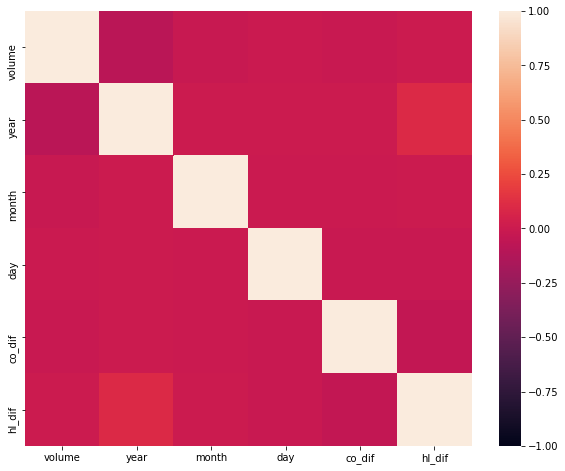

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_df.corr(), vmin=-1, vmax=1)
plt.show()

# Not too much coorelation. This looks good

In [21]:
fa = FactorAnalyzer(n_factors=25, rotation="varimax")
_ = fa.fit_transform(number)
ev, _ = fa.get_eigenvalues()

<IPython.core.display.Javascript object>

In [22]:
# # Plot eigenvalues as a scree plot
# idx = range(1, len(ev) + 1)
# plt.plot(idx, ev, marker=".")

# # Highlight points above threshold value of 1
# ev_above_thresh = ev[np.where(ev > 1)]
# idx = range(1, len(ev_above_thresh) + 1)
# plt.scatter(idx, ev_above_thresh, c="orange", zorder=5)

# # Plot threshold of 1
# plt.axhline(y=1, c="black", linestyle="--")

# # Pretty up
# plt.title("Scree Plot")
# plt.xlabel("Factors")
# plt.ylabel("Eigenvalue")
# plt.show()

<IPython.core.display.Javascript object>

# This scree plot shows 2,3,4 all over but similar. 5 features is a little under but still worth looking at

In [23]:
k_means_5 = KMeans(n_clusters=5, random_state=69)
k_means_5.fit(scaled)
y_pred = k_means_5.predict(scaled)
centroids_5 = scaler.inverse_transform(k_means_5.cluster_centers_)
number["label5"] = k_means_5.labels_

<IPython.core.display.Javascript object>

In [24]:
k_means_4 = KMeans(n_clusters=4, random_state=69)
k_means_4.fit(scaled)
y_pred = k_means_4.predict(scaled)
centroids_4 = scaler.inverse_transform(k_means_4.cluster_centers_)
number["label4"] = k_means_4.labels_





<IPython.core.display.Javascript object>

In [25]:
k_means_3 = KMeans(n_clusters=3, random_state=69)
k_means_3.fit(scaled)
y_pred = k_means_3.predict(scaled)
centroids_3 = scaler.inverse_transform(k_means_3.cluster_centers_)
number["label3"] = k_means_3.labels_



<IPython.core.display.Javascript object>

In [26]:
k_means_2 = KMeans(n_clusters=2, random_state=69)
k_means_2.fit(scaled)
y_pred = k_means_2.predict(scaled)
centroids_2 = scaler.inverse_transform(k_means_2.cluster_centers_)
number["label2"] = k_means_2.labels_


<IPython.core.display.Javascript object>

In [27]:
number

,volume,year,month,day,co_dif,hl_dif,label5,label4,label3,label2
0,3815500.0,2010,1,4,-0.089998,0.500001,0,2,1,0
1,9837300.0,2010,1,4,-0.070000,0.280000,0,2,1,0
2,1701700.0,2010,1,4,-0.320000,0.680000,0,2,1,0
3,123432400.0,2010,1,4,0.580000,2.119995,4,2,1,0
4,2455900.0,2010,1,4,0.339998,0.550002,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
822849,6431600.0,2016,12,30,-0.050003,0.570000,3,0,0,1
822850,1887100.0,2016,12,30,-0.599998,0.779999,3,0,0,1
822851,973800.0,2016,12,30,-0.110001,1.080002,3,0,0,1
822852,1938100.0,2016,12,30,-0.029999,0.620002,3,0,0,1


<IPython.core.display.Javascript object>

In [28]:
sampled = number.copy()
sampled = sampled.loc[:, ~sampled.columns.str.startswith("label")]
sample = sampled.sample(n=12345, random_state=69)
sample

,volume,year,month,day,co_dif,hl_dif
356109,1201400.0,2013,1,14,-0.080000,0.539999
801647,1552000.0,2016,10,26,0.020000,0.649997
600505,2928400.0,2015,2,11,-0.479999,0.830002
506341,1224500.0,2014,4,25,-3.830002,5.059998
663406,4786500.0,2015,8,25,-2.569999,2.710003
...,...,...,...,...,...,...
385512,5709500.0,2013,4,16,-0.100001,0.430000
343432,19057200.0,2012,12,4,0.000000,0.280000
549130,473400.0,2014,9,4,-0.400001,0.560001
752250,978500.0,2016,5,26,-0.180000,0.990002


<IPython.core.display.Javascript object>

In [29]:
# Trying hierarchical for comparison
dist_mat = squareform(pdist(sample, metric="euclid"))
clst = AgglomerativeClustering(n_clusters=5, linkage="ward", affinity="euclidean")
clst.fit(sample)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

<IPython.core.display.Javascript object>

In [30]:
# That's pretty useless imo
# plt.figure(figsize=(20, 10))
# plot_dendrogram(clst)

<IPython.core.display.Javascript object>

In [31]:
# Well... These clusters seem like they're not grouped well. Let's check value counts
sample["label"] = clst.labels_
sample.groupby("label").mean()

,volume,year,month,day,co_dif,hl_dif
label,,,,,,
0,2.176055e+08,2012.000000,5.294118,13.705882,-0.632352,2.005883
1,7.602710e+07,2012.047619,6.753968,15.674603,0.217936,1.831031
2,2.331232e+06,2013.068788,6.572062,15.928492,0.039151,1.443668
3,2.939342e+07,2012.536471,5.962353,15.764706,-0.034941,1.087482
4,1.042587e+07,2012.656385,6.358225,15.490801,-0.039118,1.269389


<IPython.core.display.Javascript object>

In [39]:
dist_mat = squareform(pdist(sample, metric="euclid"))
clst = AgglomerativeClustering(n_clusters=4, linkage="ward", affinity="euclidean")
clst.fit(sample)
sample["label4"] = clst.labels_

<IPython.core.display.Javascript object>

In [40]:
dist_mat = squareform(pdist(sample, metric="euclid"))
clst = AgglomerativeClustering(n_clusters=3, linkage="ward", affinity="euclidean")
clst.fit(sample)
sample["label3"] = clst.labels_

<IPython.core.display.Javascript object>

In [41]:
dist_mat = squareform(pdist(sample, metric="euclid"))
clst = AgglomerativeClustering(n_clusters=2, linkage="ward", affinity="euclidean")
clst.fit(sample)
sample["label2"] = clst.labels_

<IPython.core.display.Javascript object>

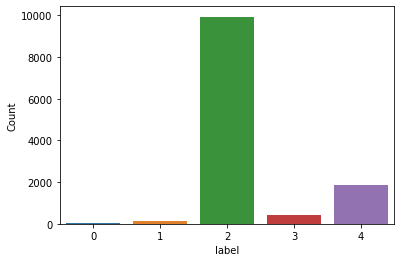

<IPython.core.display.Javascript object>

In [38]:
# hierarchical 5
# sns.countplot(x="label", data=sample)
# plt.ylabel("Count")
# plt.show()

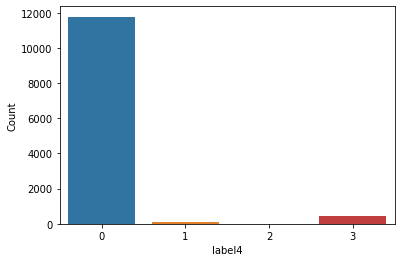

<IPython.core.display.Javascript object>

In [42]:
# sns.countplot(x="label4", data=sample)
# plt.ylabel("Count")
# plt.show()

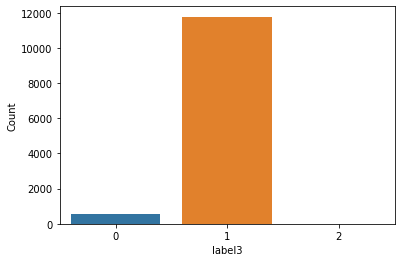

<IPython.core.display.Javascript object>

In [43]:
# sns.countplot(x="label3", data=sample)
# plt.ylabel("Count")
# plt.show()

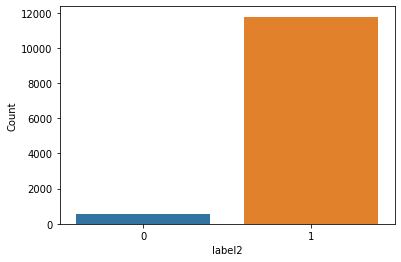

<IPython.core.display.Javascript object>

In [44]:
# sns.countplot(x="label2", data=sample)
# plt.ylabel("Count")
# plt.show()

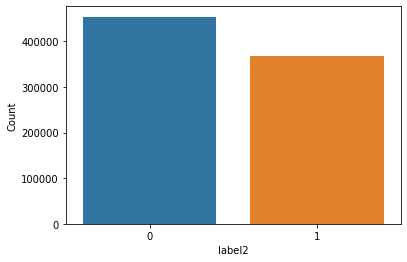

<IPython.core.display.Javascript object>

In [33]:
#2 Clusters
# sns.countplot(x="label2", data=number)
# plt.ylabel("Count")
# plt.show()

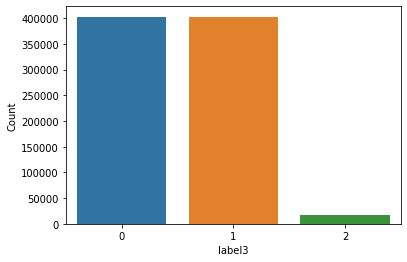

<IPython.core.display.Javascript object>

In [35]:
# 3 Clusters
# sns.countplot(x="label3", data=number)
# plt.ylabel("Count")
# plt.show()

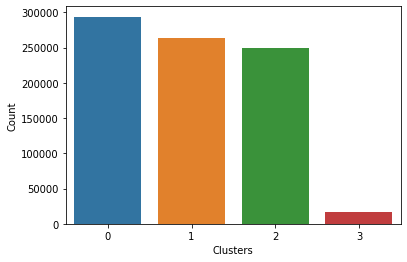

<IPython.core.display.Javascript object>

In [45]:
# # 4 clusters
# sns.countplot(x="label4", data=number)
# plt.xlabel("Clusters")
# plt.ylabel("Count")
# plt.show()

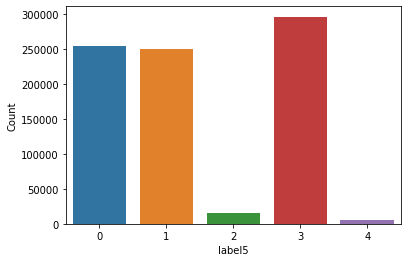

<IPython.core.display.Javascript object>

In [37]:
# 5 clusters
# sns.countplot(x="label5", data=number)
# plt.ylabel("Count")
# plt.show()

# K-means is clearly better. 4 clusters seem to be best since there are multiple columns and only one small one

# Now let's check dimension reduction techniques to see if they are helpful at all for better distinguishing clusters

In [48]:
number1 = number.loc[:, ~number.columns.str.startswith("label")]
pca = PCA(n_components=5)
pca_df_full = pca.fit_transform(scaled)
loadings = pca_loadings(pca)
loadings = pd.DataFrame(loadings)
loadings.index = number1.columns
loadings.columns = [f"component_{i}" for i in range(loadings.shape[1])]

<IPython.core.display.Javascript object>

In [63]:
pca.explained_variance_ratio_

array([0.18797589, 0.17309604, 0.16781853, 0.16675884, 0.16004107])

<IPython.core.display.Javascript object>

In [52]:
pca4 = PCA(n_components=4)
pca4_df = pca4.fit_transform(scaled)
loadings4 = pca_loadings(pca4)
loadings4 = pd.DataFrame(loadings4)
loadings4.index = number1.columns
loadings4.columns = [f"component_{i}" for i in range(loadings4.shape[1])]

<IPython.core.display.Javascript object>

In [64]:
pca4.explained_variance_ratio_

array([0.18797589, 0.17309604, 0.16781853, 0.16675884])

<IPython.core.display.Javascript object>

In [59]:
pca3 = PCA(n_components=3)
pca2_df = pca3.fit_transform(scaled)
loadings3 = pca_loadings(pca3)
loadings3 = pd.DataFrame(loadings3)
loadings3.index = number1.columns
loadings3.columns = [f"component_{i}" for i in range(loadings3.shape[1])]

<IPython.core.display.Javascript object>

In [65]:
pca3.explained_variance_ratio_

array([0.18797589, 0.17309604, 0.16781853])

<IPython.core.display.Javascript object>

In [60]:
pca2 = PCA(n_components=2)
pca2_df = pca2.fit_transform(scaled)
loadings2 = pca_loadings(pca2)
loadings2 = pd.DataFrame(loadings2)
loadings2.index = number1.columns
loadings2.columns = [f"component_{i}" for i in range(loadings2.shape[1])]

<IPython.core.display.Javascript object>

In [62]:
pca2.explained_variance_ratio_

array([0.18797589, 0.17309604])

<IPython.core.display.Javascript object>

In [61]:
# Interesting. Stocks seem to be more expensive at vertain parts of the year. The month can also cheapen a stock
loadings

,component_0,component_1,component_2,component_3,component_4
volume,-0.429141,0.620503,-0.108788,0.031723,0.509712
year,0.738119,-0.113574,-0.119921,-0.138030,0.093409
month,0.090763,-0.225311,0.563242,0.713192,0.332568
day,-0.017581,-0.063015,0.675881,-0.677557,0.278335
co_dif,-0.152681,-0.615802,-0.441789,-0.106689,0.611774
hl_dif,0.605818,0.454650,-0.107064,0.037244,0.359690


<IPython.core.display.Javascript object>

# Explaining less than 50% of data, is pretty bad. I'll check UMAP, but not looking good

# Let's check on UMAP to see if it does anything PCA doesn't

In [ ]:
# Let's see if another method would be better for dimensionality reduction. UMAP TIME!
# if i put in all of scaled, it can't deal with it. Time to random sample
umap = UMAP(n_neighbors=6, min_dist=0.3, metric="euclidean")
feeling_like_will = umap.fit_transform(sample)

# feeling_like_will

In [ ]:
feeling_like_will

In [ ]:
umap_df = pd.DataFrame(feeling_like_will, index=sample.index)
# px.scatter(umap_df, x=feeling_like_will[:, 0], y=feeling_like_will[:, 1])

In [ ]:
umap = UMAP(n_neighbors=5, min_dist=0.6, metric="euclidean")
feeling_like_will = umap.fit_transform(sample)
umap_df = pd.DataFrame(feeling_like_will, index=sample.index)
# px.scatter(umap_df, x=feeling_like_will[:, 0], y=feeling_like_will[:, 1])

In [ ]:
umap = UMAP(n_neighbors=4, min_dist=0.6, metric="euclidean")
feeling_like_will = umap.fit_transform(sample)
umap_df = pd.DataFrame(feeling_like_will, index=sample.index)
# px.scatter(umap_df, x=feeling_like_will[:, 0], y=feeling_like_will[:, 1])

# Please uncomment the above scatter plots to see visualizations of dimensionality reduction

# These feature reduction techniques do not group the data too well. I am going to continue with the non-dimensionality reduced data

In [77]:
number["label4"].value_counts()

0    293687
1    263905
2    249032
3     16230
Name: label4, dtype: int64

<IPython.core.display.Javascript object>

In [79]:
number = number.drop(columns=["label5", "label3", "label2"])

<IPython.core.display.Javascript object>

In [88]:
number.columns

Index(['volume', 'year', 'month', 'day', 'co_dif', 'hl_dif', 'label4'], dtype='object')

<IPython.core.display.Javascript object>

In [93]:
clst_df = number1.copy()
clst_df["label"] = number["label4"]
clst_means = number.groupby("label4").mean()
clst_means_tall = clst_means.T
scaled_df = pd.DataFrame(scaled, columns=number1.columns)
scaled_df["label"] = number["label4"]
scaled_clst_means = scaled_df.groupby("label").mean()

scaled_means_tall = scaled_clst_means.T

# fmt: off
scaled_means_tall["range"] = (
    scaled_means_tall.max(axis=1) - scaled_means_tall.min(axis=1)
)
# fmt: on
scaled_means_tall["sd"] = scaled_means_tall.std(axis=1)

top_distinct = scaled_means_tall.sort_values("range", ascending=False)

is_how_often = top_distinct.index.str.contains("how often do you")
is_how_involved = top_distinct.index.str.contains("how involved")

top_dem = top_distinct[~is_how_often & ~is_how_involved]
top_often = top_distinct[is_how_often]
top_involved = top_distinct[is_how_involved]

print(f"total clustered: {clst_df.shape[0]}")

print("cluster distribution")
print(clst_df["label"].value_counts())

print("Largest ranges between cluster means\n")
print(" * ranges were calc-ed on scaled means (unscaled cluster means displayed)")
print(" * sorted largest range -> smallest")
print(" * grouped into 3 categories that are not related to range")

print("\n\nGeneral differences:")
display(clst_means_tall.loc[top_dem.index].style.background_gradient(axis=1))



total clustered: 822854
cluster distribution
0    293687
1    263905
2    249032
3     16230
Name: label, dtype: int64
Largest ranges between cluster means

 * ranges were calc-ed on scaled means (unscaled cluster means displayed)
 * sorted largest range -> smallest
 * grouped into 3 categories that are not related to range


General differences:


label4,0,1,2,3
hl_dif,1.201111,1.352705,1.079496,12.021120
year,2013.262766,2014.629507,2010.931157,2013.550585
day,24.935857,9.467437,11.424913,15.733025
volume,4284170.836639,4035752.031981,7865137.180362,10725740.203327
co_dif,0.009028,0.054250,0.023742,-0.373608
month,6.558949,6.576507,6.509324,6.578312


<IPython.core.display.Javascript object>

In [81]:
# number = number.drop(columns="label4")
# sns.pairplot(number, hue="label")
# plt.show()

<IPython.core.display.Javascript object>

In [82]:
df_full["label"] = number["label4"]

<IPython.core.display.Javascript object>

In [83]:
df_full[df_full["label"] == 3]

,symbol,open,close,low,high,volume,year,month,day,co_dif,hl_dif,label
1122,GOOG,625.861078,608.261023,606.361042,625.861078,7987100.0,2010,1,6,-17.600055,19.500036,3
1123,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0,2010,1,6,-17.599998,19.500012,3
1262,PCLN,225.119995,219.080002,218.149994,226.419998,1007800.0,2010,1,6,-6.039993,8.270004,3
1589,GOOG,609.401025,594.101005,592.651008,610.001045,12876600.0,2010,1,7,-15.300020,17.350037,3
1590,GOOGL,609.400008,594.100015,592.649990,609.999993,12815700.0,2010,1,7,-15.299993,17.350003,3
...,...,...,...,...,...,...,...,...,...,...,...,...
822478,CMG,376.519989,377.320007,375.160004,382.489990,888100.0,2016,12,30,0.800018,7.329986,3
822575,GOOG,782.750000,771.820007,770.409973,782.780029,1760200.0,2016,12,30,-10.929993,12.370056,3
822576,GOOGL,803.210022,792.450012,789.619995,803.289978,1728300.0,2016,12,30,-10.760010,13.669983,3
822715,PCLN,1483.489990,1466.060059,1462.339966,1483.489990,405100.0,2016,12,30,-17.429931,21.150024,3


<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


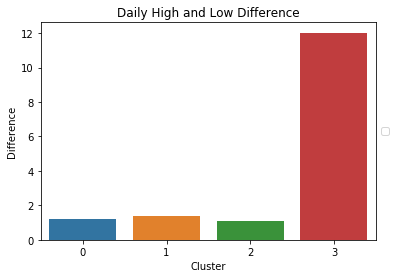

<IPython.core.display.Javascript object>

In [123]:
sns.barplot(df_full["label"], df_full["hl_dif"], ci=None)
plt.xlabel("Cluster")
plt.ylabel("Difference")
plt.title("Daily High and Low Difference")
plt.legend(title="", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()

No handles with labels found to put in legend.


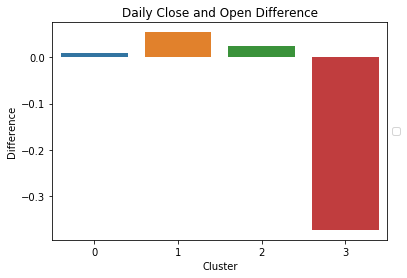

<IPython.core.display.Javascript object>

In [124]:
sns.barplot(df_full["label"], df_full["co_dif"], ci=None)
plt.xlabel("Cluster")
plt.ylabel("Difference")
plt.title("Daily Close and Open Difference")
plt.legend(title="", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()

No handles with labels found to put in legend.


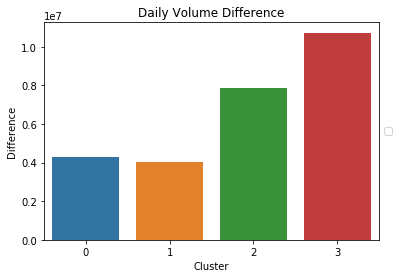

<IPython.core.display.Javascript object>

In [131]:
sns.barplot(df_full["label"], df_full["volume"], ci=None)
plt.xlabel("Cluster")
plt.ylabel("Difference")
plt.title("Daily Volume Difference")
plt.legend(title="", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()

No handles with labels found to put in legend.


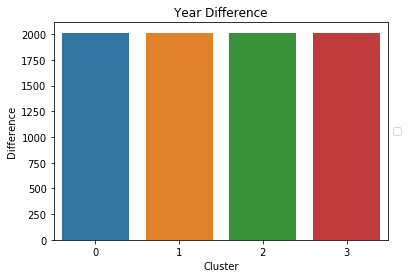

<IPython.core.display.Javascript object>

In [132]:
sns.barplot(df_full["label"], df_full["year"], ci=None)
plt.xlabel("Cluster")
plt.ylabel("Difference")
plt.title("Year Difference")
plt.legend(title="", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()

No handles with labels found to put in legend.


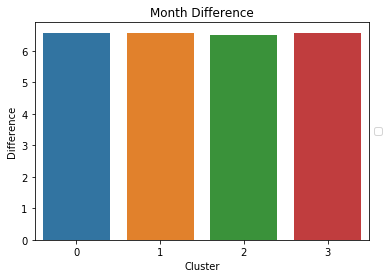

<IPython.core.display.Javascript object>

In [134]:
sns.barplot(df_full["label"], df_full["month"], ci=None)
plt.xlabel("Cluster")
plt.ylabel("Difference")
plt.title("Month Difference")
plt.legend(title="", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()

No handles with labels found to put in legend.


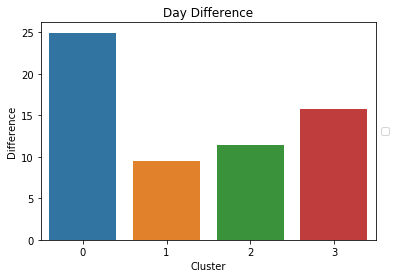

<IPython.core.display.Javascript object>

In [135]:
sns.barplot(df_full["label"], df_full["day"], ci=None)
plt.xlabel("Cluster")
plt.ylabel("Difference")
plt.title("Day Difference")
plt.legend(title="", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()

# Well some conclusions based on the above data:

# General: Groups 0 , and 2 seem to be similar in terms of open, close, low and high but differ on the difference in those. Ideally, it seems group 3 would be the one to day trade among all of these

- Cluster 0 (293687 members):
 - most likely to be the end of the month
 - Very slow gain. Most likely very stable shares

- Cluster 1 (263905 Members):
 - Very good day trade starter stocks
 - Can hold for a day and sell
 - Low stress
- Cluster 2(249032 Members):
 - These are popular stocks that most people are trading
 - Very good for those to start trading since there's positive differences and can follow more experienced
- Cluster 3(16230 Members):
 - These are where the most risk and money is to be made
 - Due to the volume, it is clearly underexplored by multiple people but has massive potential

# Let's visualize these differences

In [ ]:
sns.barplot()

# Tl;Dr Conclusion and key takeouts:

- Stocks in group 3 should be looked at closer for possible profit gain

- Stocks in group 2 should have long term analysis to see if they are beginner friendly

- 

In [70]:
# format is open close low high volume year month day co_dif hl_dif
chegg = [[2725077, 2020, 5, 20, -0.59, 1.67]]
apple = [[50980000, 2020, 5, 20, 2.48, 3.32]]
cars = [[289208, 2020, 5, 20, -1.88, 37.97]]
search = [[1864967, 2020, 5, 20, 20.02, 55]]
clust_1 = [[405100, 2016, 12, 30, -17.429931, 21.150024,]]
disney = [[25700000, 2020, 5, 20, 3.49, 4.83]]
thinkful = k_means_4.predict(scaler.transform(chegg))
pomme = k_means_4.predict(scaler.transform(apple))
auto_zone = k_means_4.predict(scaler.transform(cars))
google = k_means_4.predict(scaler.transform(search))
we_know = k_means_4.predict(scaler.transform(clust_1))
mouse = k_means_4.predict(scaler.transform(disney))

<IPython.core.display.Javascript object>

In [71]:
print(thinkful)

[1]


<IPython.core.display.Javascript object>

In [72]:
print(pomme)

[1]


<IPython.core.display.Javascript object>

In [73]:
print(auto_zone)

[3]


<IPython.core.display.Javascript object>

In [74]:
print(google)

[3]


<IPython.core.display.Javascript object>

In [75]:
# making sure that the predictor is working
print(we_know)

[3]


<IPython.core.display.Javascript object>

In [76]:
print(mouse)

[1]


<IPython.core.display.Javascript object>